## Split data into Training & Test Data and use train data for Model building 


### Example 1

Use advertising data to build a model 

In [33]:
import pandas                    as     pd
import numpy                     as     np

import seaborn                   as     sns
import matplotlib.pyplot         as     plt

import scipy.stats               as     stats
import statsmodels.api           as     sm
import statsmodels.stats.api     as     sms

from   statsmodels.compat        import lzip
from   sklearn.metrics           import mean_squared_error
from   sklearn.preprocessing     import PolynomialFeatures
from   sklearn.linear_model      import LinearRegression
from   sklearn                   import linear_model
from   statsmodels.stats         import diagnostic as diag
from   sklearn.cross_validation  import train_test_split

In [34]:
Advertising_df = pd.read_csv('./data/Advertising.csv', names = ['TV','Radio','Newspaper','Sales'], header = 0)
print(Advertising_df.info())
print(Advertising_df.head().T)

X          =   Advertising_df[['TV','Radio','Newspaper']]
y          =   Advertising_df['Sales']

print(X.shape)                            
print(y.shape)                                                           

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB
None
               1     2     3      4      5
TV         230.1  44.5  17.2  151.5  180.8
Radio       37.8  39.3  45.9   41.3   10.8
Newspaper   69.2  45.1  69.3   58.5   58.4
Sales       22.1  10.4   9.3   18.5   12.9
(200, 3)
(200,)


### Assumptions of Linear Regression

### 1) Absence of multi-collinearity

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

[variance_inflation_factor(X.values, j) for j in range(1,X.shape[1])]

[3.2854621001628961, 3.0552445106573844]

### Inference

We don't see any variable having VIF more than the threshold of 5. Hence there is no multi-collinearity.

### Build the model to get residuals

In [36]:
## Build a model
X_1       = sm.add_constant(X) 
model     = sm.OLS(y, X_1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 01 Dec 2018   Prob (F-statistic):           1.58e-96
Time:                        17:21:07   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
print(type(X_1))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### 2)  Errors between the observed and predicted values should be normally distributed

* For regressions, the test of normality applies to model's residuals and not the variables themselves. 

* We shall inspect the residuals using a probabity plot. Here the residuals will be represented as dots (in blue) should fall on the red line.

* We use Shapiro Wilk test  from scipy library to check the normality of residuals.

* Null Hypothesis: The residuals are normally distributed.

* Alternative Hypothesis: The residuals are not normally distributed.

In [38]:
shaipro_stat, pval = stats.shapiro(model.resid)
print('P value is %1.4f' %pval)

P value is 0.0000


### Inference

Since the p-value is 0, we decide that at 5% level of significance we reject the null hypotehsis and conclude that the residuals are not normally distributed.

Let us try transforming variables 

In [39]:
degrees = [2,3]

for degree in degrees:
    poly      = PolynomialFeatures(degree = degree)
    X_        = poly.fit_transform(X)
    print(X_.shape)

    ## Build a model after log transformation
    X_c         = sm.add_constant(X_) 
    model_c     = sm.OLS(y, X_c).fit()
    shaipro_stat, pval = stats.shapiro(model_c.resid)
    if  pval > 0.05:
        print('\nResiduals are normally distributed for %d degree of polynomial P value %1.4f' %(degree, pval))
        print('\nSince the p-value > 0.05, at 5% level of significance we accept the null hypotehsis')
        print('and conclude that the residuals are normally distributed')
        model_linear = model_c
        break



(200, 10)
(200, 20)


#### We shall inspect the residuals using a probabity plot. Here the residuals will be represented as dots (in blue) should fall on the red line.

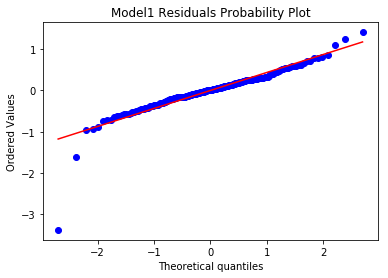

In [40]:
stats.probplot(model_c.resid, plot= plt)
plt.title("Model1 Residuals Probability Plot")
plt.show()

### Inference

This plot indicates that the model’s residuals are normally distributed. 

### 3) Homoscedasticity

Checking heteroscedasticity Using Goldfeld Quandt we test for heteroscedasticity.

* Null Hypothesis: Error terms are homoscedastic
* Alternative Hypothesis: Error terms are heteroscedastic.

In [41]:
residuals = model_c.resid
name = ['F statistic', 'p-value']

test = sms.het_goldfeldquandt(residuals, model_c.model.exog)

print(lzip(name, test))

[('F statistic', 1.6923694864230754), ('p-value', 0.0098423621433530173)]


### Inference

Since p-value is 0.94 and > 5%, we accept the null hypothesis and conclude that Error terms are homoscedastic

### 4) Checking for autocorrelation 

To ensure the absence of autocorrelation we use Ljungbox test.

* Null Hypothesis: Autocorrelation is absent.
* Alternative Hypothesis: Autocorrelation is present.


In [42]:
name = ['test statistic', 'p-value']
diag.acorr_ljungbox(residuals, lags = 1) 

lzip(name, test)

[('test statistic', 1.6923694864230754), ('p-value', 0.0098423621433530173)]

### Inference

Since p-value is 0.94 and > 5%, we accept the null hypothesis and can say that autocorrelation is not present.

### 5) Relationship between the independent and dependent variables to be linear

The residual vs fitted values plot is used to check for constant variance and linearity, and to identify potential outliers in the data.

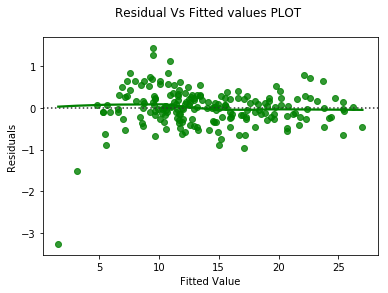

In [43]:
# Plot the residuals after fitting a linear model
ax = sns.residplot(y, residuals, lowess = True, color = "g")
ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

### Inference

The residual plot indicates that the model’s residuals are restricting to mean of zero to a great extent exhibiting linearity.

Now the after transforming the predictor variables, we have tested the assumptions of linear regression.
Our trandformed data satisfies all the assumptions of linear regression.

http://adataanalyst.com/machine-learning/guide-for-linear-regression-using-python/

https://www.listendata.com/2018/01/linear-regression-in-python.html

### Split the data into train and test datasets

* Use the train data to build a model.
* Use the test data to evaluate the model performance.
* Slit the data into 80:20 ratio to create train and test data
* Set a random seed to ensure repeatability of the results

In [44]:
feature_names  = ['1', 'a', 'b', 'c', 'asquare','ab', 'ac', 'bsquare', 'bc', 'csquare','acube', 'asquareb', 'asquarec', \
                 'bsquarea', 'abc','csquarea', 'bcube', 'bsquarec', 'csquareb', 'csube']
X_df           = pd.DataFrame(X_, columns = feature_names)
X              = X_df[['a', 'b', 'c', 'asquare','ab', 'ac', 'bsquare', 'bc', 'csquare','acube', 'asquareb', 'asquarec', \
                 'bsquarea', 'abc','csquarea', 'bcube', 'bsquarec', 'csquareb', 'csube']]
print(X.head().T)
print(X.shape)

                     0          1           2            3            4
a         2.301000e+02     44.500      17.200      151.500      180.800
b         3.780000e+01     39.300      45.900       41.300       10.800
c         6.920000e+01     45.100      69.300       58.500       58.400
asquare   5.294601e+04   1980.250     295.840    22952.250    32688.640
ab        8.697780e+03   1748.850     789.480     6256.950     1952.640
ac        1.592292e+04   2006.950    1191.960     8862.750    10558.720
bsquare   1.428840e+03   1544.490    2106.810     1705.690      116.640
bc        2.615760e+03   1772.430    3180.870     2416.050      630.720
csquare   4.788640e+03   2034.010    4802.490     3422.250     3410.560
acube     1.218288e+07  88121.125    5088.448  3477265.875  5910106.112
asquareb  2.001359e+06  77823.825   13579.056   947927.925   353037.312
asquarec  3.663864e+06  89309.275   20501.712  1342706.625  1909016.576
bsquarea  3.287761e+05  68729.805   36237.132   258412.035    21

In [45]:
x_train, x_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

### Check the shape of train and test data

In [46]:
df_names      = ['x_train shape', 'x_test shape', 'y_train shape', 'y_test shape']
shapes        = (x_train.shape, x_test.shape,  y_train.shape, y_test.shape)
lzip(df_names,shapes)

[('x_train shape', (160, 19)),
 ('x_test shape', (40, 19)),
 ('y_train shape', (160,)),
 ('y_test shape', (40,))]

### Build the model using train data

In [47]:
print(y_train.shape, x_train.shape)
print(type(x_train))
print(type(y_train))

(160,) (160, 19)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [48]:
X_train     = sm.add_constant(x_train) 

XT          = np.array(X_train)
yT          = np.array(y_train)
lm          = sm.OLS(yT, XT).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     899.8
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          3.12e-136
Time:                        17:21:08   Log-Likelihood:                -109.39
No. Observations:                 160   AIC:                             258.8
Df Residuals:                     140   BIC:                             320.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8658      0.385     10.052      0.0

In [49]:
array_names = ['Intercept', 'a', 'b', 'c', 'asquare','ab', 'ac', 'bsquare', 'bc', 'csquare','acube', 'asquareb', 'asquarec', 
                 'bsquarea', 'abc','csquarea', 'bcube', 'bsquarec', 'csquareb', 'csube']

print(lzip(array_names, lm.params))

[('Intercept', 3.8657774458546661), ('a', 0.092688849520565553), ('b', 0.034618308734181813), ('c', 0.01597361060663733), ('asquare', -0.0004661373498001817), ('ab', 0.0015105066308397643), ('ac', -0.00025859816619372726), ('bsquare', -9.3919570381979095e-06), ('bc', -0.0007483268224054325), ('csquare', 0.00029334565791866354), ('acube', 8.1533230829296047e-07), ('asquareb', -1.6885028807000976e-06), ('asquarec', 1.0005165951310666e-06), ('bsquarea', 2.399810399124809e-06), ('abc', -1.983087191449835e-06), ('csquarea', -3.3281653821695402e-07), ('bcube', -9.0788657901817184e-06), ('bsquarec', 9.7386068043123577e-06), ('csquareb', 5.2069321210296851e-06), ('csube', -3.0270876989093698e-06)]


We have the following predictor variables named as a, b and c:
* a = TV
* b = Radio
* c = Newspaper

The regression equation is given by:

Sales = 3.86577 + 0.09269 * TV + 0.03462 * Radio + 0.01597 * Newspaper -0.000466 * $TV^2$ + 0.0015105 * TV X Radio - 0.0002586 * TV X Newspaper - 9.39196 * $Radio^2$ - 0.0007483 X Radio X Newspaper + 0.0002933 * $Newspaper^2$  + 0.000000081533 * $TV^3$ - 0.0000016885 * $TV^2$ X Radio - 0.00000100052 * $TV^2$ X Newspaper - 0.0000023998 * $Radio^2$ X TV - 0.00000198309 * $TV$ * $Radio$ * $Newspaper$ - 0.000000332817 * $Newspaper^2$ * TV - 0.00000907886 * $Radio^3$ + 0.0000097386 * $Radio^2$ * Newspaper + 0.0000052069 * $Newspaper^2$ X Radio - 0.000003027 * $Newspaper^3$ 

Rsquare is 0.992 and Adj. R-squared is 0.991.

In [50]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

lin_model = LinearRegression()

lin_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Model evaluation

We will evaluate our model using RMSE and R2-score.

### Prediction Accuracy

Prediction error or residuals is the difference between the predicted target variable values and the actual target variable vaues.

Most popular measure to evaluate the model performance is Root Mean Square Error (RMSE) which is the arithmatic mean of the sum of the residuals.

The model with low RMSE is the best model among many other models.

In [51]:
# model evaluation for training set

y_train_predict = lin_model.predict(x_train)

rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))

print("The model performance for training set")

print("--------------------------------------")

print('RMSE is {}'.format(rmse))

print('R square is %1.3f' %lin_model.score(x_train, y_train))

#print('R2 score is {}'.format(r2))

print("\n")

# model evaluation for testing set

y_test_predict = lin_model.predict(x_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

print("The model performance for testing set")

print("--------------------------------------")

print('RMSE is {}'.format(rmse))

print('R square is %1.3f' %lin_model.score(x_test, y_test))

The model performance for training set
--------------------------------------
RMSE is 0.47938555090261337
R square is 0.992


The model performance for testing set
--------------------------------------
RMSE is 0.4379771894151509
R square is 0.991


###  In class lab :  Practice exercise 1 

Use the red wine data and predict the target variable, wine quality using the predictor variables (1 to 11). 

* Split data into Training & Test Data and use train data for Model building. 
* Test the assumptions of normality.
* Evaluate model performance by finding RMSE.
* Interpret the coefficients and write the significant variables.

In [52]:
import pandas as pd
wine_data   = pd.read_csv('./data/winequality-red.csv', header = 0, sep = ';')
print(wine_data.info())
print(wine_data.shape)
print(wine_data.head(5).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
(1599, 12)
                            0        1       2       3        4
fixed acidity          7.4000   7.8000   7.800  11.200   7.4000
volatile acidity       0.7000   0.8800   0.760   0.280   0.7000
citric acid            0.0000   0.0000   0.040   0.560   0.0000
residual sugar    

## Simple Logistic Regression

** Logistic regression models** are used to analyze the relationships between a target or dependent variable (DV) and explanatory or independent variables (IV) when the the dependent variable is binary or dichotomous. 

### Example 2

#### Toxicity Dataset example 


An experiment is done to test the effect of a toxic substance on insects. The data originate from the textbook, Applied Linear Statistical Models by Kutner, Nachtsheim, Neter, & Li.

At each of six dose levels, 250 insects are exposed to the substance and the number of insects that die is counted . We can use python to calculate the observed probabilities as the number of observed deaths out of 250 for each dose level.

In [53]:
import pandas               as     pd
import numpy                as     np

from   sklearn.linear_model import LogisticRegression

In [54]:
toxicity_df = pd.DataFrame({'Dose':[1,2,3,4,5,6] , 'Size': [250, 250, 250, 250, 250, 250], 'Deaths':[28,53,93,126,172,197]})

In [55]:
print(toxicity_df)

   Deaths  Dose  Size
0      28     1   250
1      53     2   250
2      93     3   250
3     126     4   250
4     172     5   250
5     197     6   250


In [56]:
import array as arr

Dose_L = [28, 53, 93, 126, 172, 197]

Death_df = pd.DataFrame()

for i in range(6):
    
    m = Dose_L[i]
    n = 250 - m
    Zeros = np.zeros(m).astype(int)
    Ones  = np.ones(n).astype(int)
    
    Death_N = list(arr.array('I', Zeros))
    Death_Y = list(arr.array('I', Ones))

    Death_L = Death_N + Death_Y
    Death_D = {'Dose' : list(np.repeat(i+1,250)), 'Death': Death_L}
   
    Death_Dict = Death_D
    df            = pd.DataFrame(Death_Dict)
    Death_df      = Death_df.append(df)

In [57]:
toxicity_data = Death_df
print("\nData Frame ")
print(toxicity_data.info())
print(toxicity_data.head(2))
X = toxicity_data['Dose']
y = toxicity_data['Death'].astype('category')


Data Frame 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 249
Data columns (total 2 columns):
Death    1500 non-null int64
Dose     1500 non-null int64
dtypes: int64(2)
memory usage: 35.2 KB
None
   Death  Dose
0      0     1
1      0     1


In [58]:
import statsmodels.formula.api as smf
model= smf.logit(formula="Death ~ C(Dose)", data= toxicity_data).fit()
lg   = model.summary()
print(lg)

Optimization terminated successfully.
         Current function value: 0.559614
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Death   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1494
Method:                           MLE   Df Model:                            5
Date:                Sat, 01 Dec 2018   Pseudo R-squ.:                  0.1858
Time:                        17:21:09   Log-Likelihood:                -839.42
converged:                       True   LL-Null:                       -1031.0
                                        LLR p-value:                 1.320e-80
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0705      0.201     10.324      0.000       1.677       2.464
C(Dose)[T.2]    -0.7576

###  Log odds, odds ratio and success probability

In [59]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
Intercept,7.928571,5.479202e-25,5.351674,11.746276
C(Dose)[T.2],0.468808,2.783203e-03,0.285353,0.770208
C(Dose)[T.3],0.212923,1.049417e-10,0.133166,0.340448
C(Dose)[T.4],0.124124,1.371763e-18,0.077988,0.197552
C(Dose)[T.5],0.057197,4.177022e-32,0.035553,0.092017
C(Dose)[T.6],0.033932,1.077957e-40,0.020654,0.055748


### Interpretation

* We observe the McFadden $R^2$ to be 18.58%. The model fit is fair.

####  Rule of thumb: Values from 0.2-0.4 indicate (in McFadden's words) excellent model fit. 

* The overall model is significant indicated by a LLR p-value < 0.05, which allows us to look at the rest of the results. 
* All the explanatory variables are having significant effect on the log odds of the target variable as indicated by the z values < 0.05.

**Calculation of  McFadden $R^2$:**

For each of the two categories of the dependent variable, calculate the mean of the predicted probabilities of an event. Then, take the difference between those two means.

### Interpretation of Log Odds 

###  Since exposure to the toxic subtance at dosage level 1 was dropped from the analysis, it is the comparison group and plays an important role in interpreting the other categories. 

* If insects are exposed to the toxic subtance at dosage level 2, there is a -0.757561 (decrease) in the log odds that they die when compared to exposure to the toxic subtance at dosage level 1

* If insects are exposed to the toxic subtance at dosage level 3, there is a -1.546827 (decrease) in the log odds that they die when compared to exposure to the toxic subtance at dosage level 1

* If insects are exposed to the toxic subtance at dosage level 4, there is a -2.086473 (decrease) in the log odds that they die when compared to exposure to the toxic subtance at dosage level 1

* If insects are exposed to the toxic subtance at dosage level 5, there is a  -2.861259 (decrease) in the log odds that they die when compared to exposure to the toxic subtance at dosage level 1

* If insects are exposed to the toxic subtance at dosage level 6, there is a  -3.3834 (decrease) in the log odds that they die when compared to exposure to the toxic subtance at dosage level 1

### Interpretation of Odds ratio

#### Holding all other variables constant:

* Insects that die with exposure to the toxic subtance at dosage level 2 is 0.47 times that of exposure to the toxic subtance at dosage level 1
    
* Insects that die with exposure to the toxic subtance at dosage level 3 is 0.21 times that of exposure to the toxic subtance at dosage level 1

* Insects that die with exposure to the toxic subtance at dosage level 4 is 0.12 times that of exposure to the toxic subtance at dosage level 1

* Insects that die with exposure to the toxic subtance at dosage level 5 is 0.06 times that of exposure to the toxic subtance at dosage level 1

* Insects that die with exposure to the toxic subtance at dosage level 6 is 0.03 times that of exposure to the toxic subtance at dosage level 1

When interpreting odd ratios, any value greater than 1 indicates an increase in the odds, i.e. an increase in the likely hood, of that group being in the outcome variable, and any value less than 1 indicates a decrease in the odds, i.e. an decrease in the likely hood.

###   In class lab : Practice Exercise 2

Predict if a given loan will be defaulted (bad_flag = 1) or not based on 14 other features.

| Sl No | Variable | Data Type | Remarks |
| ---- | ---------- | ------------ | ---------------------- |
| 1 | bad_flag | Categorical | 1 Default 0 No default | 
| 2 | tenure | Integer | Tenure of loan in months | 
| 3 | margin_amount | Integer | Margin amount to paid by the customer to avail the loan | 
| 4 | financed_amount | Integer | Amount Financed to the customer towards the loan | 
| 5 | exist | Categorical | 1 Existing customer 0 New customer | 
| 6 | cibil score | Integer | CIBIL score of the customer | 
| 7 | concurrent_loans | Integer | Number of concurrent loans at the time of availing this loan |
| 8 | total_income | Integer | Total income of the customer |
| 9 | is_rented | Categorical | 1 Rented 0 OWn accommodation | 
| 10 | Gender | Categorical | 1 Male 0 Female | 
| 11 | is_married | Categorical | 1 Married 0 Not Married | 
| 12 | is_selfemployed | Categorical | 1 Self Employed 0 Not self employed | 
| 13 | age | Integer | Age of the customer | 
| 14 | monthly_expenses | Integer | Monthly expenses incurred by the customer |
| 15 | bank_savings | Integer | Bank savings of the customer |




Find the Log odds, odds ratio and success probability and interpret.

In [60]:
import pandas as pd

loan_data    =    pd.read_csv('./data/Loan_Default_Final.csv')
print(loan_data.info())
print(loan_data.head().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 15 columns):
bad_flag            24783 non-null int64
tenure              24783 non-null int64
margin_amount       24783 non-null int64
financed_amount     24783 non-null int64
exist               24783 non-null int64
cibil score         24783 non-null int64
concurrent_loans    24783 non-null int64
total_income        24783 non-null int64
is_rented           24783 non-null int64
Gender              24783 non-null int64
is_married          24783 non-null int64
is_selfemployed     24783 non-null int64
age                 24783 non-null int64
monthly_expenses    24783 non-null int64
bank_savings        24783 non-null int64
dtypes: int64(15)
memory usage: 2.8 MB
None
                       0        1        2        3        4
bad_flag               0        0        0        0        0
tenure                36       36       47       23       40
margin_amount        140     5079     1147     27

In [61]:
loan_data['bad_flag']        = loan_data['bad_flag'].astype('category')
loan_data['exist']           = loan_data['exist'].astype('category')
loan_data['is_rented']       = loan_data['is_rented'].astype('category')
loan_data['Gender']          = loan_data['Gender'].astype('category')
loan_data['is_married']      = loan_data['is_married'].astype('category')
loan_data['is_selfemployed'] = loan_data['is_selfemployed'].astype('category')

print(loan_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 15 columns):
bad_flag            24783 non-null category
tenure              24783 non-null int64
margin_amount       24783 non-null int64
financed_amount     24783 non-null int64
exist               24783 non-null category
cibil score         24783 non-null int64
concurrent_loans    24783 non-null int64
total_income        24783 non-null int64
is_rented           24783 non-null category
Gender              24783 non-null category
is_married          24783 non-null category
is_selfemployed     24783 non-null category
age                 24783 non-null int64
monthly_expenses    24783 non-null int64
bank_savings        24783 non-null int64
dtypes: category(6), int64(9)
memory usage: 1.8 MB
None


### Take home exercises

In [ ]:
### Exercise 1

Use Carseats data to predict Sales.

* Split data into Training & Test Data and use train data for Model building. 
* Test the assumptions of normality.
* Evaluate model performance by finding RMSE.
* Interpret the coefficients and write the significant variables.

#### About data

A data frame with 400 observations on the following 11 variables. 

| Sl No | Variable | Description |
| ---- | ------------ | -------------------------------------------------- |
| 1 | Sales | Unit sales (in thousands) at each location | 
| 2 | CompPrice | Price charged by competitor at each location | 
| 3 | Income | Community income level (in thousands of dollars) | 
| 4 | Advertising | Local advertising budget for company at each location (in thousands of dollars) | 
| 5 | Population | Population size in region (in thousands) | 
| 6 | Price | Price company charges for car seats at each site | 
| 7 | ShelveLoc | A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site | 
| 8 | Age | Average age of the local population | 
| 9 | Education | Education level at each location | 
| 10 | Urban | A factor with levels No and Yes to indicate whether the store is in an urban or rural location | 
| 11 | US | A factor with levels No and Yes to indicate whether the store is in the US or not | 


In [62]:
import pandas as pd

data = pd.read_csv('./data/Carseats.csv')
print(data.head())
print(data.info())

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null object
Age            400 non-null i

### Exercise 2

### Predict if a given specimen (row in dataset) is benign or malignant, based on 30 other cell features.

The objective is to identify each of a number of benign or malignant classes.

Use the Breast Cancer Wisconsin (Diagnostic) Database which is available in sklearn.datasets.

* Find the McFadden R square and interpret
* How many variables are significant in predicting the target variable?
* Find the log odds, odds ratio and interpret.

In [63]:
# BreastCancer

from    sklearn.datasets import load_breast_cancer
import   pandas          as     pd
cancer   = load_breast_cancer()
print(cancer .DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [64]:
X    = pd.DataFrame(cancer.data, columns=cancer.feature_names) # Predictor variables
y    = cancer.target # Target or Response variable

print(X.info())
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

## END